_Lambda School Data Science, Unit 2_
 
# Sprint Challenge: Predict Steph Curry's shots 🏀

For your Sprint Challenge, you'll use a dataset with all Steph Curry's NBA field goal attempts. (Regular season and playoff games, from October 28, 2009, through June 5, 2019.) 

You'll use information about the shot and the game to predict whether the shot was made. This is hard to predict! Try for an accuracy score in the high 50's or low 60's. The dataset was collected with the [nba_api](https://github.com/swar/nba_api) Python library.

In [98]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import category_encoders as ce

url = 'https://drive.google.com/uc?export=download&id=1fL7KPyxgGYfQDsuJoBWHIWwCAf-HTFpX'
df = pd.read_csv(url, parse_dates=['game_date']).set_index('game_date')
assert df.shape == (13958, 19)

This Sprint Challenge has two parts. To demonstrate mastery on each part, do all the required, numbered instructions. To earn a score of "3" for the part, also do the stretch goals.

## Part 1. Prepare to model

### Required

1. **Do train/validate/test split.** Use the 2009-10 season through 2016-17 season to train, the 2017-18 season to validate, and the 2018-19 season to test. NBA seasons begin in October and end in June. You'll know you've split the data correctly when your train set has 11081 observations, your validation set has 1168 observations, and your test set has 1709 observations.
2. **Begin with baselines for classification.** Your target to predict is `shot_made_flag`. What is the baseline accuracy for the validation set, if you guessed the majority class for every prediction?
3. **Use Ordinal Encoding _or_ One-Hot Encoding,** for the categorical features you select.
4. **Train a Random Forest _or_ Logistic Regression** with the features you select.

### Stretch goals
Engineer at least 4 of these 5 features:

- **Homecourt Advantage**: Is the home team (`htm`) the Golden State Warriors (`GSW`) ?
- **Opponent**: Who is the other team playing the Golden State Warriors?
- **Seconds remaining in the period**: Combine minutes remaining with seconds remaining, to get the total number of seconds remaining in the period.
- **Seconds remaining in the game**: Combine period, and seconds remaining in the period, to get the total number of seconds remaining in the game. A basketball game has 4 periods, each 12 minutes long.
- **Made previous shot**: Was Steph Curry's previous shot successful?

### start exploring the data by printing out the first 5 rows

In [44]:
df.head()

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,htm,vtm,season_type,scoremargin_before_shot
game_date,,,,,,,,,,,,,,,,,,,
2009-10-28,20900015,4,Stephen Curry,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,GSW,HOU,Regular Season,2.0
2009-10-28,20900015,17,Stephen Curry,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,1,GSW,HOU,Regular Season,0.0
2009-10-28,20900015,53,Stephen Curry,1,6,2,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-60,129,0,GSW,HOU,Regular Season,-4.0
2009-10-28,20900015,141,Stephen Curry,2,9,49,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,19,-172,82,0,GSW,HOU,Regular Season,-4.0
2009-10-28,20900015,249,Stephen Curry,2,2,19,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-68,148,0,GSW,HOU,Regular Season,0.0


### create new column using the index for date of game

In [45]:
df['game_date'] = df.index

In [46]:
# check the types of features
df.dtypes

game_id                             int64
game_event_id                       int64
player_name                        object
period                              int64
minutes_remaining                   int64
seconds_remaining                   int64
action_type                        object
shot_type                          object
shot_zone_basic                    object
shot_zone_area                     object
shot_zone_range                    object
shot_distance                       int64
loc_x                               int64
loc_y                               int64
shot_made_flag                      int64
htm                                object
vtm                                object
season_type                        object
scoremargin_before_shot           float64
game_date                  datetime64[ns]
dtype: object

In [47]:
# check to see if there are any null valuess
df.isnull().sum()

game_id                    0
game_event_id              0
player_name                0
period                     0
minutes_remaining          0
seconds_remaining          0
action_type                0
shot_type                  0
shot_zone_basic            0
shot_zone_area             0
shot_zone_range            0
shot_distance              0
loc_x                      0
loc_y                      0
shot_made_flag             0
htm                        0
vtm                        0
season_type                0
scoremargin_before_shot    0
game_date                  0
dtype: int64

### Split into train / val / test

In [48]:
# train = 2009-2010 to 2016-2017
# val = 2017
# test = 2018
df['year'] = df['game_date'].dt.year
df['month'] = df['game_date'].dt.month

# Train = June 2017 and before
upto_2016 = df[(df['year'] <= 2016)]
during_2017 = df[(df['month'] < 7) & (df['year'] == 2017)]
train = pd.concat([upto_2016, during_2017])

# Validate = 2017 season 10/2017 - 6/2018
end_2017 = df[(df['year'] == 2017) & (df['month'] >= 10)]
beg_2018 = df[(df['year'] == 2018) & (df['month'] < 7)]
val = pd.concat([end_2017, beg_2018])

# test = 2018 season which is all data from 10/2018 on
end_2018 = df[(df['year'] == 2018) & (df['month'] >= 10)]
beg_2019 = df[(df['year'] == 2019)]
test = pd.concat([end_2018, beg_2019])

assert train.shape[0] == 11081 
assert val.shape[0] == 1168 
assert test.shape[0] == 1709

train.shape, val.shape, test.shape

((11081, 22), (1168, 22), (1709, 22))

In [50]:
target = 'shot_made_flag'

features = df.drop(columns=target).columns

X_train = train[features]
y_train = train[target]

X_val = val[features]
y_val = val[target]

X_test = test[features]

### build baseline model using 'shot_made_flag' and guessing the majority class

In [54]:
y_train.value_counts(normalize=True)

0    0.527209
1    0.472791
Name: shot_made_flag, dtype: float64

In [62]:
majority = y_train.mode()[0]
y_pred = [majority]*len(y_val)

In [64]:
# printout the baseline accuracy score
accuracy = accuracy_score(y_val, y_pred)
print(f'Baseline model using majority class has and accuracy of {accuracy} on the validation set')

Baseline model using majority class has and accuracy of 0.5162671232876712 on the validation set


### select features, encode categorical features and train Random Forest model

In [67]:
target = target = 'shot_made_flag'

features = [
    'period',
    'minutes_remaining',
    'seconds_remaining',
    'action_type',
    'shot_type',
    'shot_zone_basic',
    'shot_zone_area',
    'shot_zone_range',
    'shot_distance',
    'loc_x',
    'loc_y',
    'season_type',
    'scoremargin_before_shot'
]

X_train = train[features]
y_train = train[target]

X_val = val[features]
y_val = val[target]

X_test = test[features]
y_test = test[target]

In [82]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    RandomForestClassifier(n_estimators=100,
                           max_depth = 10,
                           n_jobs=-1,
                           random_state=42)
)

# Fit on train, score on val, predict on test
pipeline.fit(X_train, y_train)
train_acc = pipeline.score(X_train, y_train)
val_acc = pipeline.score(X_val, y_val)
y_pred_val = pipeline.predict(X_val)
y_pred_test = pipeline.predict(X_test)

## Part 2. Evaluate models

### Required
1. Get your model's **validation accuracy.** (Multiple times if you try multiple iterations.)
2. Get your model's **test accuracy.** (One time, at the end.)
3. Get and plot your Random Forest's **feature importances** _or_ your Logistic Regression's **coefficients.**
4. Imagine this is the confusion matrix for a binary classification model. **Calculate accuracy, precision, and recall for this confusion matrix:**

<table>
  <tr>
    <td colspan="2" rowspan="2"></td>
    <td colspan="2">Predicted</td>
  </tr>
  <tr>
    <td>Negative</td>
    <td>Positive</td>
  </tr>
  <tr>
    <td rowspan="2">Actual</td>
    <td>Negative</td>
    <td style="border: solid">85</td>
    <td style="border: solid">58</td>
  </tr>
  <tr>
    <td>Positive</td>
    <td style="border: solid">8</td>
    <td style="border: solid"> 36</td>
  </tr>
</table>


### Stretch goals
- Calculate F1 score for the provided, imaginary confusion matrix.
- Plot a real confusion matrix for your basketball model, with row and column labels.
- Print the classification report for your model.

### print train and validation accuracy for Random Forest model

In [74]:
print(f'Train Accuracy: {train_acc}')
print(f'Validation Accuracy: {val_acc}')

Train Accuracy: 0.7336882952802094
Validation Accuracy: 0.6121575342465754


### print Test accuracy score

In [89]:
print(f'Test Accuracy: {accuracy_score(y_test, y_pred_test)}')

Test Accuracy: 0.6266822703335284


### plot feature importance

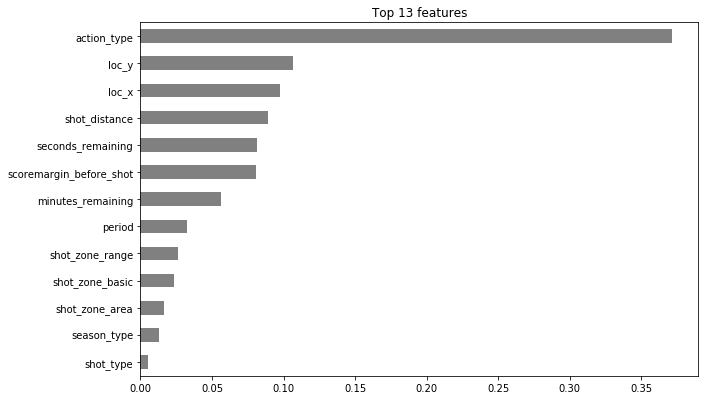

In [79]:
encoder = pipeline.named_steps['ordinalencoder']
tree = pipeline.named_steps['randomforestclassifier']

feature_names = encoder.transform(X_val).columns

importances = pd.Series(tree.feature_importances_, feature_names)

# Plot feature importances
n = len(features)
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

### plot confusion matrix for validation set

In [84]:
cm = confusion_matrix(y_val, y_pred_val)
cm

array([[373, 230],
       [223, 342]], dtype=int64)

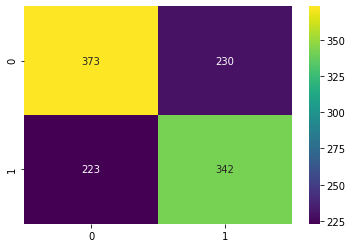

In [86]:
sns.heatmap(cm, cmap='viridis', annot=True, fmt='d');

### calulate accuracy, precision and recall by hand on validation set

In [110]:
# Accuracy
# total predictions
total = len(y_pred_val)
correct = sum(y_val == y_pred_val)
accuracy = correct/total

# precision for made shot or shot_made_flag == 1
true_pos_1 = sum((y_pred_val == 1) & (y_val == 1))
false_pos_1 = sum((y_pred_val == 1) & (y_val == 0))
precision_1 = (true_pos_1/(true_pos_1+false_pos_1))

# precision for missed shot or shot_made_flag == 0
true_pos_0 = sum((y_pred_val == 0) & (y_val == 0))
false_pos_0 = sum((y_pred_val == 0) & (y_val == 1))
precision_0 = (true_pos_0/(true_pos_0+false_pos_0))

# recall for made shot or shot_made_flag == 1
true_neg_1 = sum((y_pred_val == 0) & (y_val == 0))
false_neg_1 = sum((y_pred_val == 0) & (y_val == 1))
recall_1 = (true_pos/(true_pos+false_neg))

# recall for missed shot or shot_made_flag == 0
true_neg_0 = sum((y_pred_val == 1) & (y_val == 1))
false_neg_0 = sum((y_pred_val == 1) & (y_val == 0))
recall_0 = (true_pos_0/(true_pos_0+false_neg_0))

print('Accuracy: {:.2f}'.format(accuracy))

print('pred 0 Precision: {:.2f}'.format(precision_0))
print('pred 1 Precision: {:.2f}'.format(precision_1))

print('pred 0 Recall: {:.2f}'.format(recall_0))
print('pred 1 Recall: {:.2f}'.format(recall_1))


Accuracy: 0.61
pred 0 Precision: 0.63
pred 1 Precision: 0.60
pred 0 Recall: 0.62
pred 1 Recall: 0.61


In [99]:
print(classification_report(y_val, y_pred_val))

              precision    recall  f1-score   support

           0       0.63      0.62      0.62       603
           1       0.60      0.61      0.60       565

    accuracy                           0.61      1168
   macro avg       0.61      0.61      0.61      1168
weighted avg       0.61      0.61      0.61      1168

